## Project2-Part2- SC, AL, NT



In [1]:
import pkg_resources
import subprocess
import sys
import os

REQUIRED = {
  'spacy', 'scikit-learn', 'numpy', 'pandas', 'torch', 
  'pyfunctional', 'textblob', 'seaborn', 'matplotlib', 'torch'
}

installed = {pkg.key for pkg in pkg_resources.working_set}
missing = REQUIRED - installed

if missing:
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

import numpy as np
import glob
import pandas as pd
from textblob import TextBlob
from typing import List
import seaborn as sns
import matplotlib.pyplot as plt

From the original experimentation (https://arxiv.org/pdf/1809.04444.pdf) we'll use the same train and test split. 

In [2]:
# dataset git repo
if not os.path.exists("hate-speech-dataset"):
  !git clone https://github.com/Vicomtech/hate-speech-dataset.git
    
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to /home/chowdh83/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /home/chowdh83/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/chowdh83/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/chowdh83/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     /home/chowdh83/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /home/chowdh83/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


In [3]:
def get_data(paths: List[str], group: str):
  
    sets = []
    for p in paths:

        with open(p) as f:
            file_id = p.split('/')[-1].split('.')[0]
            sets.append((file_id, f.read(), group))

    return pd.DataFrame(sets, columns=["file_id", "text", "gSet"])

In [4]:
idLabels = pd.read_csv('hate-speech-dataset/annotations_metadata.csv')[["file_id", "label"]]

In [5]:
train_data = get_data(glob.glob('./hate-speech-dataset/sampled_train/*.txt'), 'train')
test_data = get_data(glob.glob('./hate-speech-dataset/sampled_test/*.txt'), 'test')

train_data = train_data.join(idLabels.set_index('file_id'), on='file_id')
test_data = test_data.join(idLabels.set_index('file_id'), on='file_id')

comb_data = train_data.append(test_data).reset_index(drop=True)

# print label distributions
print("Test dataset:")
print(test_data['label'].value_counts())
print("")
print("Train dataset:")
print(train_data['label'].value_counts())
print("")

print("Total datase shape:", comb_data.shape)
comb_data.tail()

Test dataset:
noHate    239
hate      239
Name: label, dtype: int64

Train dataset:
hate      601
noHate    554
Name: label, dtype: int64

Total datase shape: (1633, 4)


,file_id,text,gSet,label
1628,32923728_3,And now this clip suggests they were suffering...,test,hate
1629,33045538_3,Apparently the Jews ca n't take it when the tr...,test,hate
1630,33463853_1,Whether or not one chooses to eat meat is a ve...,test,noHate
1631,33661913_1,the money he is giving away to refugees and th...,test,noHate
1632,33677053_2,Now I get it !,test,noHate


We first extracted the following features to get a better understanding of the data:
1. sentence length
2. word count
3. sentiment (polarity)
4. subjectivity

In [6]:
strSer = comb_data['text'].str
txtBlob = comb_data['text'].apply(lambda s: TextBlob(s))

comb_data['sentence_len'] = strSer.len()
comb_data['word_count'] = strSer.split().apply(lambda ls: len(ls))
comb_data['polarity'] = txtBlob.apply(lambda blob: blob.sentiment.polarity)
comb_data['subjectivity'] = txtBlob.apply(lambda blob: blob.sentiment.subjectivity)

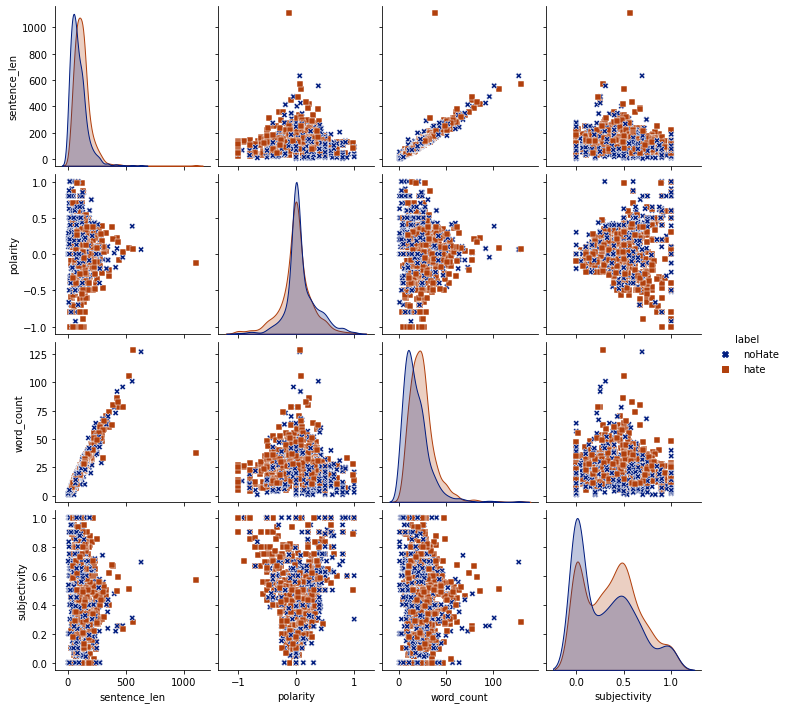

In [9]:
data_plot = comb_data[['sentence_len', 'polarity', 'word_count', 'subjectivity', 'label']]
markers = {"hate": "s", "noHate": "X"}
sns.pairplot(data_plot, hue="label", palette="dark", markers = markers)

As seen from the graphs above, these metrics are not very seperable. Their distributions align on top of each other.

In [12]:
import spacy
from spacy.lang.en.examples import sentences 
from pandas import DataFrame, Series
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from functional import seq
import numpy as np
import pandas as pd
from numpy import log, mean
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics import silhouette_score

In [13]:
nlp = spacy.load("en_core_web_sm")

In [50]:
def log_LhArr(src: Series, ref: Series):
    """
    Vectorized log likelihood test. 
    @param src: sum of tokens in the source group
    @param ref: sum of tokens in the reference group
    """
    src_count: int = src.sum()
    ref_count: int = ref.sum()
  
    agg = (src + ref) / (src_count + ref_count)
    e1 = src_count * agg
    e2 = ref_count * agg

    p1 = src * log(src / e1)
    p2 = ref * log(ref / e2)

    return 2 * (p1 + p2)
  

In [51]:
def LogLikelihoodWrds(docWordMatrix: DataFrame, labels, topN):
    """
    Prints top words from log likelihood test.
    """
    label1, label2 = set(labels)

    aggDf = docWordMatrix.assign(label=labels).groupby('label').sum().T

    aggDf = aggDf.assign(
    l1Diff = aggDf[label1] - aggDf[label2], 
    l2Diff = aggDf[label2] - aggDf[label1],

    llikelihood = log_LhArr(aggDf[label1].replace(0, 0.01), aggDf[label2].replace(0, 0.01))
    )

    label1_i = aggDf['l1Diff'] > 0
    label2_i = aggDf['l1Diff'] < 0

    l1 = aggDf[label1_i].sort_values(by='llikelihood', ascending=False)[:topN]['llikelihood']
    l2 = aggDf[label2_i].sort_values(by='llikelihood', ascending=False)[:topN]['llikelihood']

    print(f"\nTop {label1.upper()} tokens by likelihood:\n")
    print(l1)

    print(f"\nTop {label2.upper()} tokens by likelihood:\n")
    print(l2)

    return (l1, l2)

In [16]:
def hateTokenizer(text: str, spacyModel=nlp):
    
    doc = spacyModel(text)

    return seq(token for token in doc)\
    .filter(lambda t: t.is_alpha)\
    .filter_not(lambda t: t.is_stop)\
    .map(lambda t: t.lemma_.lower())\
    .to_list()

In [17]:
#convert to Data frame
def ToDf(corpus, tokenizer=hateTokenizer, idf=False):
  
    vectorizer = (
    TfidfVectorizer(tokenizer=tokenizer, lowercase=False) 
    if idf else
    CountVectorizer(tokenizer=tokenizer, lowercase=False))
    
    X = vectorizer.fit_transform(corpus)

    return pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())



In [18]:
count_df = ToDf(comb_data['text'])
l1, l2 = LogLikelihoodWrds(count_df, comb_data['label'].tolist(), 10)


Top HATE tokens by likelihood:

black    44.709483
jews     37.334256
negro    25.396914
ape      23.801547
race     23.410760
scum     22.269892
non      17.626058
groid    17.557590
jew      15.704856
mud      14.436472
Name: llikelihood, dtype: float64

Top NOHATE tokens by likelihood:

post       22.241187
youtube    20.193442
year       15.207984
pm         13.989821
thread     13.741175
talk       12.447087
meet       11.653780
site       11.653780
info       10.766367
teacher    10.753152
Name: llikelihood, dtype: float64


In [19]:
models = []

for n in range(2, 9):
    lda = LatentDirichletAllocation(n_components=n, random_state=0)
    lda.fit(count_df)
    models.append((n, lda))

In [52]:
def topWordsPerComponent(componentsMatrix, words=count_df.columns.tolist(), topN: int=10):
    """
    Print top keywords for each component in componentsMatrix.
    @param componentsMatrix: components matrix from factorization. Shape: (n_topics, tokens_len).
    @param words: list with words/tokens. Usually the columns of the document-word matrix.
    @param Length must be equal to *tokens_len* (see parameter above).
    @param topN: number of words to print per topic.
    """
    df = pd.DataFrame(componentsMatrix.T, index=words)
    cols = [f"topic-{t}" for t in df.columns]

    finalDf = pd.DataFrame([
    df.sort_values(by=col, ascending=False)[:topN].index
    for col in df.columns
    ]).T

    print(finalDf.set_axis(cols, axis=1))

In [53]:
for n, model in models:
    if n > 5:
        break
    
    print("\n", f"Top Keywords With {n} Topics:", "\n")
    topWordsPerComponent(model.components_)


 Top Keywords With 2 Topics: 

   topic-0 topic-1
0    black   white
1    white    like
2   people    race
3     time  people
4     good      go
5    negro     not
6     come    year
7      way   think
8  country    look
9      day    want

 Top Keywords With 3 Topics: 

   topic-0 topic-1  topic-2
0    white   white    black
1    negro    like    white
2     time    race   people
3     tell      go     like
4     come     not    think
5  country    know     year
6   people  people     good
7      day     kid    start
8    black    want  ireland
9     know    look      get

 Top Keywords With 4 Topics: 

  topic-0 topic-1 topic-2  topic-3
0   white   white   black     like
1    time    race   white  country
2    know    like  people   people
3   negro      go    like    negro
4    come     not    year  ireland
5    like   woman    good     tell
6  people  people    hate      try
7     day     non     not      kid
8   thank    know   think      get
9   think   think     way    black

 

In [22]:
hateText = comb_data[comb_data['label'] == 'hate']['text'].str.lower()
docs = list(nlp.pipe(hateText, disable=["ner", "textcat"]))

In [23]:
nouns = set([token.lemma_ 
  for doc in docs
  for token in doc
  if token.dep_ == 'nsubj' and not token.is_stop and len(token) > 2
])

pairs = [(hateText.str.contains(nn).sum(), nn) for nn in nouns]
targetsDf = pd.DataFrame(pairs, columns=["sentence_count", "target"])

In [24]:
def cleanDfText(df, col_remove='target', col_sort='sentence_count', show=20):
    """
    Datafram without a particular word from col_remove is printed 
    """
    newDf = df.copy()
    removed = list()
  
    while True:
        word = input("Word to remove (enter 'q' to exit):")

        if word == 'q':
            return removed, newDf

        newDf = newDf[newDf[col_remove] != word]\
                  .sort_values(by=col_sort, ascending=False)\
                  .reset_index(drop=True)
    
        removed.append(word)
        clear_output(wait=True)
        print(newDf.head(show))
    
        # clear notebook I/O
        In.clear()
        Out.clear()

In [25]:
toRemove = ['er','lack','one','use','man','ted','people','way','race',
 'red','cause','non','ape','rat','time','son','country','don','thing',
 'school','world','child','hate','work','kid','lie','nation','scum','hell','mud',
 'filth','human','sex','house','being','car','arm','place','crime','guy',
 'crap','breed','news','town','male'
]

targetsDf[~targetsDf['target'].str.contains("|".join(toRemove))]\
  .sort_values(by="sentence_count", ascending=False)\
  .reset_index(drop=True).head(15)

,sentence_count,target
0,396,ing
1,200,white
2,74,jew
3,70,negro
4,39,let
5,37,africa
6,33,jews
7,31,good
8,26,nig
9,25,ireland


In [ ]:
#using BERT to perform Binary Classification
import pkg_resources
import subprocess
import pickle
import shutil
import time
import sys
import os

from enum import Enum
from functools import partial

REQUIRED = {
  'spacy', 'scikit-learn', 'numpy', 'pandas', 'torch', 'transformers'
}

installed = {pkg.key for pkg in pkg_resources.working_set}
missing = REQUIRED - installed

if missing:
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

from typing import List, Dict, Tuple
import glob


import torch
from torch import torch
from torch.utils.data import Dataset

from dataclasses import dataclass

from sklearn.metrics import accuracy_score


from transformers import PreTrainedTokenizer, PreTrainedModel
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification



import numpy as np
import pandas as pd
from pandas import DataFrame


from transformers import DistilBertModel, DistilBertPreTrainedModel
from transformers import Trainer, TrainingArguments




from transformers import EvalPrediction

In [ ]:
def readData(paths: List[str], group: str):
    pairs = []
    for p in paths:
    
        with open(p) as f:
            file_id = p.split('/')[-1].split('.')[0]
            pairs.append((file_id, f.read(), group))
  
    return pd.DataFrame(pairs, columns=["file_id", "text", "gSet"])

idLabels = pd.read_csv('hate-speech-dataset/annotations_metadata.csv')[["file_id", "label"]]

trainDf = readData(glob.glob('./hate-speech-dataset/sampled_train/*.txt'), 'train')
testDf = readData(glob.glob('./hate-speech-dataset/sampled_test/*.txt'), 'test')

trainDf = trainDf.join(idLabels.set_index('file_id'), on='file_id')
testDf = testDf.join(idLabels.set_index('file_id'), on='file_id')

print(trainDf.info(), '\n')
print(testDf.info())

In [57]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
# save original model set of weights. They we'll be used later over multiple iterations
torch.save(model.state_dict(), "./tempBertState.pt")

loading file vocab.txt from cache at /home/chowdh83/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/043235d6088ecd3dd5fb5ca3592b6913fd516027/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /home/chowdh83/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/043235d6088ecd3dd5fb5ca3592b6913fd516027/tokenizer_config.json
loading configuration file config.json from cache at /home/chowdh83/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/043235d6088ecd3dd5fb5ca3592b6913fd516027/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,


In [58]:
#classes for the data
class TokenizedInput:
    """
    Class for tracking single tokenized inputs 
    (for Pytorch Dataset __getitem__).
    """
    inputs: List[int]
    masks: List[int]
    label: int

    def tokenizedInput(self):
        return (self.inputs, self.masks, self.label)

class HateSpeechDataset(Dataset):
    """
    PyTorch DataSet Class
    """
    
    def __init__(self, corpus: List[str], labels: List[str], tokenizer: PreTrainedTokenizer=tokenizer,truncate=True,padding=True):
        self.tokenizer = tokenizer
        self.trunc = truncate
      
        self.corpusTokenized = tokenizer(corpus, padding=padding)
        self.labels = labels
    
    def __getitem__(self, i):
        inputs = self.corpusTokenized['input_ids'][i]
        masks = self.corpusTokenized['attention_mask'][i]
    
        return TokenizedInput(self._truncate(inputs) if self.trunc else inputs, self._truncate(masks, is_mask=True) if self.trunc else masks,
                      self.labels[i])
    
    
    def __len__(self):
        return len(self.labels)
    
    
    def _truncate(self, vector: List[int], is_mask=False, sep_token_num=102):
        """
        Truncate vector length to model max input size 
        """
        limit = self.tokenizer.model_max_length
    
        if len(vector) <= limit:
              return vector
        elif is_mask:
              return vector[:limit]
        else:
            last = sep_token_num if vector[-1] not in (0, sep_token_num) else 0
            return vector[:limit - 1] + [last]
  
  


In [59]:
def collator(items: List[TokenizedInput]) -> Dict:
    """
    converts list of items into a single dictionary
    Used by the Pytorch Dataloader inside the Trainer class
    """
    # keys for DistilBertForSequenceClassification
    input_k = 'input_ids'
    mask_k = 'attention_mask'
    label_k = 'labels'

    # zip input_ids, attention_mask and labels together
    zipped =  list(map(list, zip(*[t.tokenizedInput() for t in items])))
    
    # convert lists to pyTorch tensors
    inputs, masks, labels = list(map(lambda ls: torch.tensor(ls), zipped))

    return {input_k: inputs, mask_k: masks, label_k: labels}


In [60]:
def prepareDf(df: DataFrame, textCol='text', labelsCol='label'):
    """get columns to be fed to Dataset object"""
    return {"corpus": df[textCol].tolist(), "labels": df[labelsCol].map({'hate': 1, 'noHate': 0})}


In [61]:
def metrics(pred: EvalPrediction):
  
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    mapper = lambda n: True if n == 1 else False

    hatePreds = preds[[mapper(l) for l in labels]]
    noHatePreds = preds[[mapper(l) for l in 1 - labels]]

    return {
      'accHate': accuracy_score(hatePreds, np.ones_like(hatePreds)),
      'accNoHate': accuracy_score(noHatePreds, np.zeros_like(noHatePreds)),
      'accAll': accuracy_score(labels, preds),
  }

In [62]:
#train and test data sets in the correct format

train_dataset = HateSpeechDataset(**prepareDf(trainDf))
test_dataset = HateSpeechDataset(**prepareDf(testDf))
train_ds_mock = HateSpeechDataset(**prepareDf(trainDf[:20]))
test_ds_mock = HateSpeechDataset(**prepareDf(testDf[:20]))

In [63]:
def trainingArgs(epochs, trainDir, batchSizeTrain=16, batchSizeEval=32,training_set_len=len(train_dataset)):
      """Return a TrainingArguments instance to be passed to Trainer class."""
      # calculate total training steps 
      totalSteps = int((training_set_len / batchSizeTrain) * epochs)
      # use 5% of all training steps as warmup
      warmup = int(totalSteps * 0.05)
     
      return TrainingArguments(output_dir=f"./{trainDir}/results", logging_dir=f"./{trainDir}/logs",

        overwrite_output_dir=True,
        

        per_device_train_batch_size=batchSizeTrain,   
        per_device_eval_batch_size=batchSizeEval, 

        num_train_epochs=epochs,
        warmup_steps=warmup,   

        logging_steps=9999,
        save_steps=9999,
        save_total_limit=1,

        # standard arguments
        learning_rate=5e-5,
        weight_decay=1e-2,
      )

In [64]:
# training arguments 
tDir = "training"
saveModelDir = "tuned-bert"
epochsList = [2, 3, 4]

embArgs= trainingArgs(2, trainDir = tDir)
trainDs = train_dataset
testDs = test_dataset


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [65]:
####currently this function does not work#####

#Utility function to clear log file 


# from pathlib import Path

# def rmdir(directory):
#     directory = Path(directory)
#     for item in directory.iterdir():
#         if item.is_dir():
#             rmdir(item)
#         else:
#             item.unlink()
#     directory.rmdir()



In [70]:
finalMetrics = []

for epoch in epochsList:
    
    #each iteration with the original set of weights
    model.load_state_dict(torch.load("./tempBertState.pt"))

    embArgs.num_train_epochs = epoch

    trainer = Trainer(
    model=model,                         
    args=embArgs,   
    data_collator=collator,

    train_dataset=trainDs,         
    eval_dataset=testDs,
    compute_metrics=metrics
    )

    trainer.train()
    evaMetrics: Dict = trainer.evaluate()
    trainLoss: float = trainer.evaluate(trainDs)['eval_loss']

    finalMetrics.append(
        {"epoch": epoch, "eval_train_loss": trainLoss, **evaMetrics}
    )

    trainer.save_model(f"./{saveModelDir}/epoch-{epoch}")

  # clean logs 
#this is not yet fucntional
    shutil.rmtree(f"./{tDir}", ignore_errors=True)

/home/chowdh83/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1155
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 146


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 478
  Batch size = 32


***** Running Evaluation *****
  Num examples = 1155
  Batch size = 32
Saving model checkpoint to ./tuned-bert/epoch-2
Configuration saved in ./tuned-bert/epoch-2/config.json
Model weights saved in ./tuned-bert/epoch-2/pytorch_model.bin
/home/chowdh83/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1155
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 219


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 478
  Batch size = 32


***** Running Evaluation *****
  Num examples = 1155
  Batch size = 32
Saving model checkpoint to ./tuned-bert/epoch-3
Configuration saved in ./tuned-bert/epoch-3/config.json
Model weights saved in ./tuned-bert/epoch-3/pytorch_model.bin
/home/chowdh83/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1155
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 292


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 478
  Batch size = 32


***** Running Evaluation *****
  Num examples = 1155
  Batch size = 32
Saving model checkpoint to ./tuned-bert/epoch-4
Configuration saved in ./tuned-bert/epoch-4/config.json
Model weights saved in ./tuned-bert/epoch-4/pytorch_model.bin


In [71]:
#Metrics tuned data set
tunedDf = pd.DataFrame(finalMetrics)
tunedDf

,epoch,eval_train_loss,eval_loss,eval_accHate,eval_accNoHate,eval_accAll,eval_runtime,eval_samples_per_second,eval_steps_per_second
0,2.0,0.163536,0.486043,0.778243,0.841004,0.809623,24.2420,19.718,0.619
1,3.0,0.061849,0.581608,0.824268,0.799163,0.811715,23.9648,19.946,0.626
2,4.0,0.024778,0.742290,0.849372,0.782427,0.815900,24.8790,19.213,0.603
